Visualizing and Understanding networks
===

In the notebook, we introduce the tools that are use in this repository to illustrate the network studied in the differents problems. The goal of those representation is to gain a better understanding of problem at stack. 


We first import the packages we need to build our visualisation.

In [14]:
# Database Providing the datasets
import pymongo as pm
# Data manipulation
import pandas as pd
# Network 
import networkx as nx
# Datavisualization tool
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

(if you have troubles instaling basemap on an anaconda environnement see: https://github.com/conda-forge/basemap-feedstock/issues/30)

Collecting the dataset
---

Prepare the database client to makes queries, and collect the dataset we need. The data are store in a database MongoDB organised by **topic** and **author**. Given those two elements you can decide which database and which collection to use.

In [15]:
mongo_host='ns396089.ip-37-59-38.eu'
mongo_port=32771

author= "Mark S. Daskin"
topic = "NETWORK-AND-DISCRETE-LOCATION"

client = pm.MongoClient(mongo_host, mongo_port)

# Collection where we wich to store our problem
problems = client[topic]["datasets"] # client.[db name].[collection name]

Query one dataset and select it based on the metadatas. The relevant metadata to seach on in our cas are the **author** and the **name** of the problem (using the key dataset).

In [16]:
# fetch the first problem matching our search criteras
q = {
    "metadata.author": "Mark S. Daskin",
    "metadata.dataset": "49-nodes"
} # query select the desired intances
f = None # filter | select the desired fields
record = problems.find_one(q,f)

Reformat the dataset to be easy to use via **pandas**. The datasets we have downloaded contains contains the **geographic information** of cities in the USA (longitude, and latitide) as well as **demographic datas** and cost indicator.

In [17]:
df= pd.DataFrame.from_dict(record["data"])
df= df.set_index(['ID'])
df.head()

,LONGITUDE,LATITUDE,STATE POP,CITY POP,FIXED COST,CITY
ID,,,,,,
1,-121.467360,38.566850,29760021,369365,115800,< Sacramento CA >
2,-73.799017,42.665750,17990455,101082,101800,< Albany NY >
11,-84.422592,33.762900,6478216,394017,71200,< Atlanta GA >
12,-77.474584,37.531050,6187358,203056,66600,< Richmond VA >
13,-71.017892,42.336029,6016425,574283,161400,< Boston MA >


## Visualising the data

First we convert our dataFrame into a Graph by usinf **netwokx**. Note that the function `add_nodes_from` takes as input a list of tuple `(node, attribute)` thus we need make a small data manipulation: `df.T.to_dict().items()` provide the pair `(key, value)` which is exactly what we want.

In [18]:
G = nx.Graph()
G.add_nodes_from(df.T.to_dict().items())

We stored the metadatas in each node to simplify further computation. The next piece of code generate list of attributes such as the location and size of node to be use in the visualization.

In [22]:
pos = {n:(d["LONGITUDE"],d["LATITUDE"]) for n,d in G.nodes.items()}
node_size  = [ x / 1500 for n,x in G.nodes.data("CITY POP")]
node_color = [ x for n,x in G.nodes.data("FIXED COST")]

With all the elements in we finally display the map of all the cities based on their location on number of citizen.

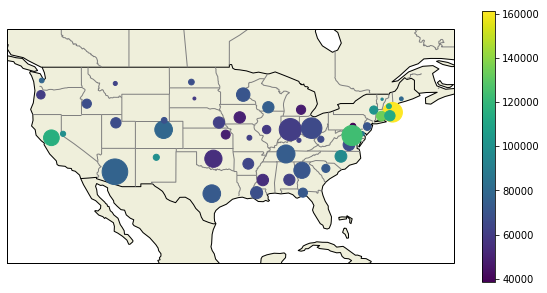

In [23]:
plt.figure(figsize=(10,5))

# 1. Create the map with cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
## Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

# 2. Plot the graph on the map
nc = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
#nx.draw_networkx_labels(G, pos, labels=dict(G.nodes.data("CITY")))

plt.colorbar(nc)